In [45]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

def load_and_preprocess(filename_train,filename_test):
    # Load the CSV file into a Pandas DataFrame
    df = pd.read_csv(filename_train)
    # Perform one-hot encoding on the categorical columns
    categorical_cols = [2,5,6,7,8,9,10,11,12,13,14,15,16,21,22,23,24,25,27,28,29,30,31,32,33,35,39,40,41,42,53,55,57,58,60,63,64,65,72,73,74,78,79]
    df1 = pd.read_csv(filename_test)
    df_cols = df.iloc[:, categorical_cols]
    df1_cols = df1.iloc[:, categorical_cols]
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
    one_hot_encoder.fit(df_cols)
    encoded_cols = one_hot_encoder.transform(df1_cols).toarray()
    df1_encoded_cols = pd.DataFrame(encoded_cols, columns=one_hot_encoder.get_feature_names_out())
    df1 = pd.concat([df1.drop(columns=df1.columns[categorical_cols]), df1_encoded_cols], axis=1)


    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_cols = pd.DataFrame(encoder.fit_transform(df.iloc[:, categorical_cols]), columns=encoder.get_feature_names_out(df.columns[categorical_cols]))

    # Concatenate the original DataFrame with the encoded columns
    df = pd.concat([df.drop(columns=df.columns[categorical_cols]), encoded_cols], axis=1)

    # Create a MinMaxScaler object
    scaler = StandardScaler()

    # Apply the scaler to the selected column
    df.iloc[:, 1:37] = scaler.fit_transform(df.iloc[:, 1:37])
    df1.iloc[:, 1:37] = scaler.fit_transform(df1.iloc[:, 1:37])

    # Remove all columns whose name contains the string "nan"
    columns_to_drop = df.filter(like='nan', axis=1).columns
    df = df.drop(columns=columns_to_drop)
    columns_to_drop = df1.filter(like='nan', axis=1).columns
    df1 = df1.drop(columns=columns_to_drop)

    cols = list(df.columns)
    cols.append(cols.pop(37))
    df = df[cols]

    df = df.fillna(0)
    df1 = df1.fillna(0)

    # Save the normalized DataFrame to a new CSV file
    #df1.to_csv('new.csv', index=False)
    #df.to_csv('encoded_data.csv', index=False)

    return df,df1

def train_linear(df_train,df_test):
    data = df_train

    # Split the data into inputs and outputs
    data = data.iloc[:,1:]
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values

    # Convert the data to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float)
    y_tensor = torch.tensor(y, dtype=torch.float)

    #print(X_tensor.shape)

    # Define the linear regression model
    class LinearRegression(torch.nn.Module):
        def __init__(self, input_size):
            super(LinearRegression, self).__init__()
            self.linear = torch.nn.Linear(input_size, 1)

        def forward(self, x):
            out = self.linear(x)
            return out


    # Define the hyperparameters
    input_size = X_tensor.shape[1]
    learning_rate = 0.0001
    num_epochs = 1000
    lambda_reg = 1

    # Initialize the model
    model = LinearRegression(input_size)

    # Define the loss function and the optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_reg)

    # Train the model
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        #print(loss)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress
        if (epoch + 1) % 100 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))

    # Evaluate the model
    with torch.no_grad():
        predicted = model(X_tensor)
        total_loss = criterion(predicted, y_tensor)
        print('Total loss: {:.4f}'.format(total_loss.item()))
    #print(outputs)
    X_test = df_test.iloc[:, 1:].values

    # Convert the data to PyTorch tensors
    X_tensor_test = torch.tensor(X_test, dtype=torch.float)
    outputs = model(X_tensor_test)
    print(outputs)


def train_mlp(df_train,df_test,train_losses,test_losses):
    class MLP(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(MLP, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_size, hidden_size2)
            self.fc3 = nn.Linear(hidden_size2, hidden_size3)
            self.fc4 = nn.Linear(hidden_size3, output_size)

        def forward(self, x):
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
            x = self.relu(x)
            x = self.fc3(x)
            x = self.relu(x)
            x = self.fc4(x)
            return x

    first_col = df_train.iloc[:,1]
    df_train = df_train.iloc[:,1:]
    features = df_train.drop('SalePrice', axis=1).values
    labels = df_train['SalePrice'].values
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.3,
                                                                                random_state=42)
    input_size = features.shape[1]
    hidden_size = features.shape[1]
    hidden_size2 = features.shape[1] // 2
    hidden_size3 = features.shape[1] // 4
    output_size = 1
    model = MLP(input_size, hidden_size, output_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.02)


    epochs = 1000000
    previous_loss = float('inf')
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        outputs = model(torch.tensor(train_features, dtype=torch.float32))
        loss = criterion(outputs.squeeze(), torch.tensor(train_labels, dtype=torch.float32))
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            if epoch % 1000 == 0:
                print(f'Epoch [{epoch}/{epochs}]\n Train Loss: {loss.item():.4f}')
            with torch.no_grad():
                predicted = model(torch.tensor(test_features, dtype=torch.float32))
                predicted = predicted.view(-1)
                total_loss = criterion(predicted, torch.tensor(test_labels, dtype=torch.float32))
                if epoch % 1000 == 0:
                    print(' Test loss:  {:.4f}'.format(total_loss.item()))
                train_losses.append(loss)
                test_losses.append(total_loss)
                if total_loss > previous_loss or total_loss < 10000**2 :
                    print("Final result:")
                    print(f'Epoch [{epoch}/{epochs}]\n Train Loss: {loss.item():.4f}')
                    print(' Test loss:  {:.4f}'.format(total_loss.item()))
                    break
                previous_loss = total_loss

    X_test = df_test.iloc[:, 1:].values

    X_tensor_test = torch.tensor(X_test, dtype=torch.float32)
    outputs = model(X_tensor_test)
    outputs = pd.DataFrame(outputs.detach().numpy())
    outputs.insert(0, 'Id', range(1461, 1461 + len(outputs)))
    outputs.columns = ['Id', 'SalePrice']

    outputs.to_csv('out.csv', index=False)


train_losses = []
test_losses = []
df_train,df_test = load_and_preprocess('train.csv','test.csv')
train_mlp(df_train,df_test,train_losses,test_losses)



Epoch [0/1000000]
 Train Loss: 38892838912.0000
 Test loss:  39380828160.0000
Epoch [1000/1000000]
 Train Loss: 8370755584.0000
 Test loss:  9180642304.0000
Epoch [2000/1000000]
 Train Loss: 1431362176.0000
 Test loss:  1502975744.0000
Epoch [3000/1000000]
 Train Loss: 1185213312.0000
 Test loss:  1253885952.0000
Epoch [4000/1000000]
 Train Loss: 1004822976.0000
 Test loss:  1102020864.0000
Epoch [5000/1000000]
 Train Loss: 860614592.0000
 Test loss:  994155968.0000
Epoch [6000/1000000]
 Train Loss: 745541952.0000
 Test loss:  927992128.0000
Epoch [7000/1000000]
 Train Loss: 655562240.0000
 Test loss:  899433280.0000
Epoch [8000/1000000]
 Train Loss: 584571008.0000
 Test loss:  881872320.0000
Epoch [9000/1000000]
 Train Loss: 508575008.0000
 Test loss:  851064256.0000
Final result:
Epoch [9700/1000000]
 Train Loss: 441859328.0000
 Test loss:  843958976.0000


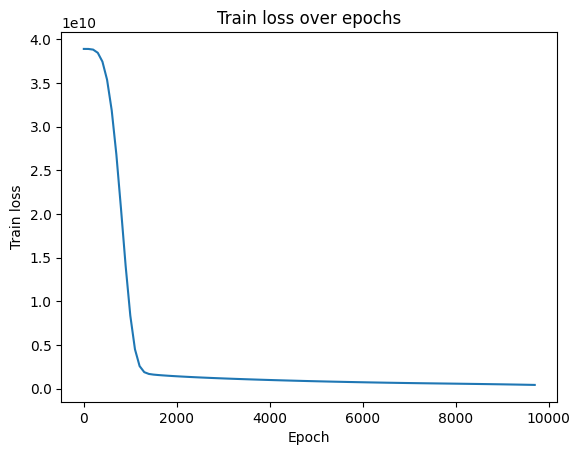

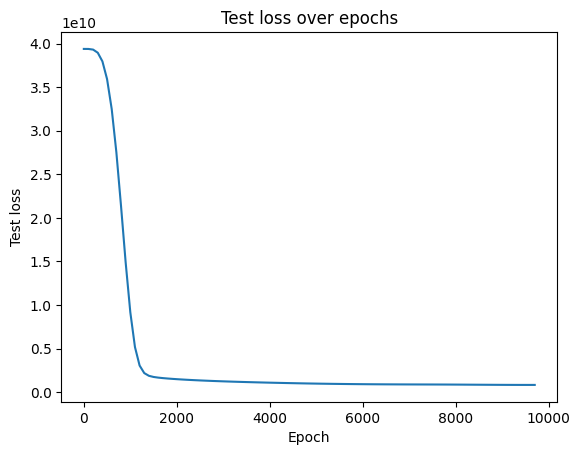

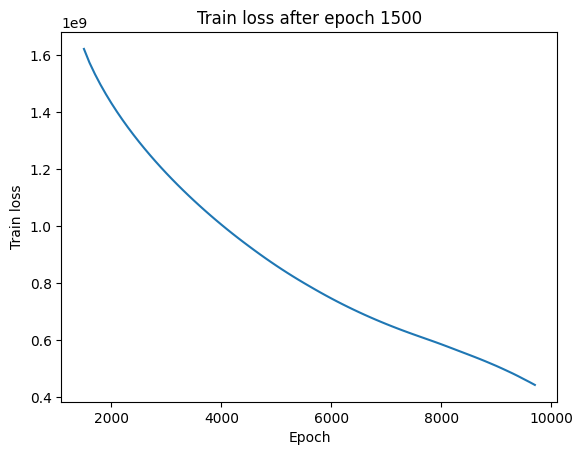

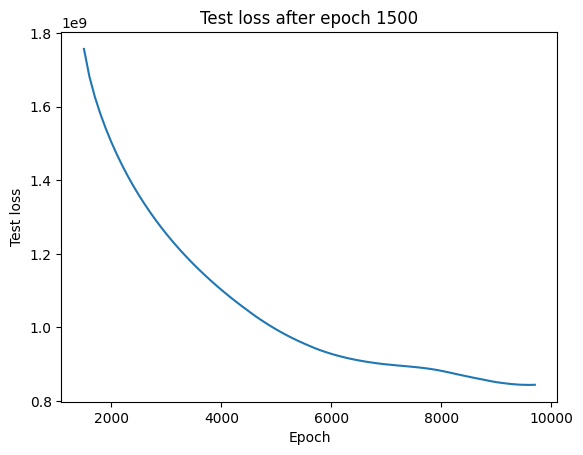

In [46]:
import matplotlib.pyplot as plt

y_train = []
y_test = []
x = []
for i in range(len(train_losses)):
    x.append(i*100)
    y_train.append(train_losses[i].detach().numpy())
    y_test.append(test_losses[i].numpy())
startswith = 15
plt.plot(x,y_train)
plt.xlabel('Epoch')
plt.ylabel('Train loss')
plt.title('Train loss over epochs')
plt.show()
plt.plot(x,y_test)
plt.xlabel('Epoch')
plt.ylabel('Test loss')
plt.title('Test loss over epochs')
plt.show()
plt.plot(x[startswith::],y_train[startswith::])
plt.xlabel('Epoch')
plt.ylabel('Train loss')
plt.title('Train loss after epoch '+str(startswith)+"00")
plt.show()
plt.plot(x[startswith::],y_test[startswith::])
plt.xlabel('Epoch')
plt.ylabel('Test loss')
plt.title('Test loss after epoch '+str(startswith)+"00")
plt.show()